In [14]:
import sys
from pathlib import Path
import ProbabilisticParcellation.functional_profiles as fp
import ProbabilisticParcellation.hierarchical_clustering as cl
import ProbabilisticParcellation.similarity_colormap as cm
import Functional_Fusion.dataset as ds
import matplotlib.pyplot as plt
import ProbabilisticParcellation.functional_profiles as fp
import ProbabilisticParcellation.util as ut
import nitools as nt
import pandas as pd
import seaborn as sb
import numpy as np


base_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/ProbabilisticParcellationModel/Atlases/'
if not Path(base_dir).exists():
    base_dir = '/srv/diedrichsen/data/Cerebellum/ProbabilisticParcellationModel/Atlases/'
if not Path(base_dir).exists():
    base_dir = '/Users/callithrix/Documents/Projects/Functional_Fusion/'
if not Path(base_dir).exists():
    raise (NameError('Could not find base_dir'))
    

In [15]:
atlas = 'MNISymC2'

# load model
mname = f'/Models_03/NettekovenSym32_space-{atlas}'
fileparts = mname.split('/')
split_mn = fileparts[-1].split('_')
info, model = ut.load_batch_best(mname)


# load labels and cmap
lut_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/ProbabilisticParcellationModel/Atlases/'
_, cmap, labels = nt.read_lut(lut_dir +
                              f'{fileparts[-1].split("_")[0]}.lut')
labels = labels[1:]

# load profile
profile = pd.read_csv(
    f'{ut.model_dir}/Atlases/Profiles/{fileparts[-1].split("_")[0]}_profile_group.tsv', sep="\t"
)

profile_indiv = pd.read_csv(
    f'{ut.model_dir}/Atlases/Profiles/{fileparts[-1].split("_")[0]}_profile_individ.tsv', sep="\t"
)




In [16]:
# Get similarity matrices
l, functional_sim, spatial_sim, ind = cl.similarity_matrices(mname)
# Make diagonal into zeros
np.fill_diagonal(functional_sim, 0)
np.fill_diagonal(spatial_sim, 0)


In [17]:
def mark_similar_region(l, regions, similarity, number = 2):
    ax = plt.gca()
    cmap = plt.get_cmap('tab10')
    # Mark most similar region
    for r in regions:
        print(f'\nRegion: {r}')
        idx = l.tolist().index(r)
        max_indices = np.argsort(similarity[:, idx])[::-1][:number]
        for i, maxidx in enumerate(max_indices):
            print(f'{l[maxidx]}')
            # color_index = i
            color_rgb = cmap(i)
            ax.add_patch(plt.Rectangle((idx - .5, maxidx - .5), 1, 1,
                                       fill=False, edgecolor=color_rgb, lw=3))
            



Region: A3L
M3L
M2L
A2L

Region: A4L
A2L
M3L
D4L

Region: A3L
M4L
A2L
M2L

Region: A4L
M4L
A3L
D2L


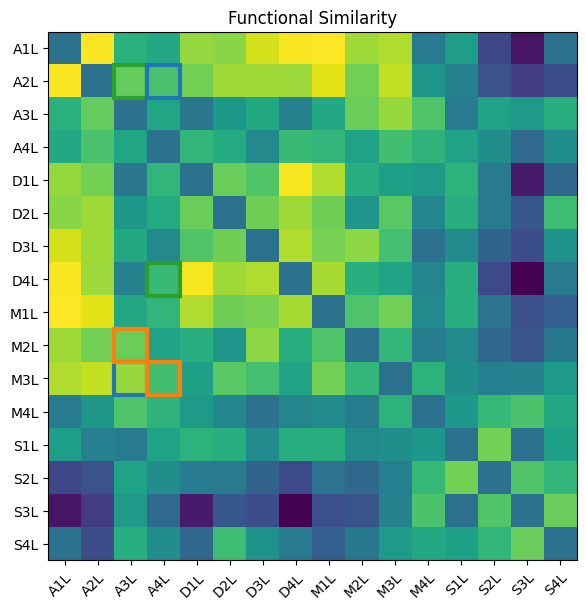

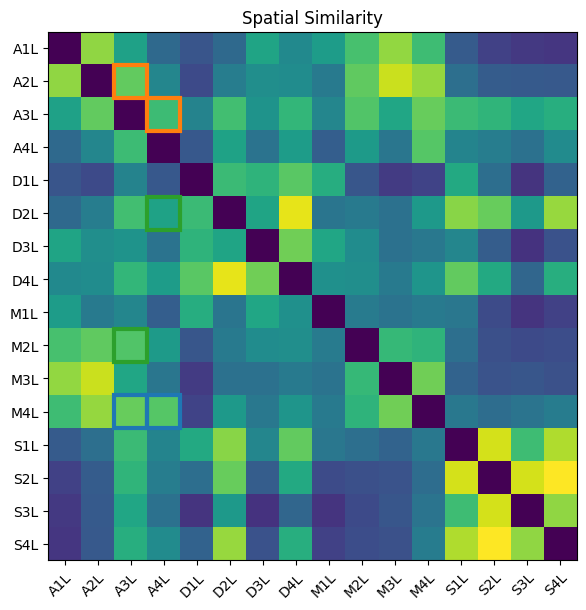

In [18]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(1, 2, 1)
ax.imshow(functional_sim)
ax.set_title('Functional Similarity')
ax.set_xticks(np.arange(len(l)))
ax.set_yticks(np.arange(len(l)))
ax.set_xticklabels(l)
_ = ax.set_yticklabels(l)
_ = plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

mark_similar_region(l, ['A3L', 'A4L'], functional_sim, number=3)



plt.figure(figsize=(15, 10))
ax = plt.subplot(1, 2, 1)
ax.imshow(spatial_sim)
ax.set_title('Spatial Similarity')
ax.set_xticks(np.arange(len(l)))
ax.set_yticks(np.arange(len(l)))
ax.set_xticklabels(l)
_ = ax.set_yticklabels(l)
_ = plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

mark_similar_region(l, ['A3L', 'A4L'], spatial_sim, number=3)

## Explore functional profiles in A3-A4 regions in the MDTB dataset

In [13]:
networks = ['M', 'A', 'S']
regions = sorted([label for label in profile.columns if label[0] in networks])
regions = sorted(regions, key=lambda x: networks.index(x[0]))

# Make colour codes into colours
reg_colors = ['red', 'orange', 'limegreen',
              'darkgreen', 'blue', 'purple', 'slateblue', 'darkviolet']
reg_colors = sb.color_palette(reg_colors, n_colors=len(regions))



In [230]:
data_group = profile[profile.dataset=='MDTB']
data_group = data_group[['condition'] + regions]
data_group= data_group.melt(id_vars='condition',var_name='region',value_name='score')
# Split region into side and region
data_group['side']=data_group.region.str[-1]
data_group['reg']=data_group.region.str[0:2]
data_group['net'] = data_group.region.str[0]
# Split condition into task, difficulty, and material   
data_group['task']=[x.split('-')[0] for x in data_group.condition]


In [231]:
data_indiv = profile_indiv[profile_indiv.dataset=='MDTB']
data_indiv = data_indiv[['condition'] + regions]
data_indiv= data_indiv.melt(id_vars='condition',var_name='region',value_name='score')
# Split region into side and region
data_indiv['side']=data_indiv.region.str[-1]
data_indiv['reg']=data_indiv.region.str[0:2]
data_indiv['net'] = data_indiv.region.str[0]
# Split condition into task, difficulty, and material   
data_indiv['task']=[x.split('-')[0] for x in data_indiv.condition]

Text(0.5, 0.98, 'Social - Individual')

<Figure size 1500x600 with 0 Axes>

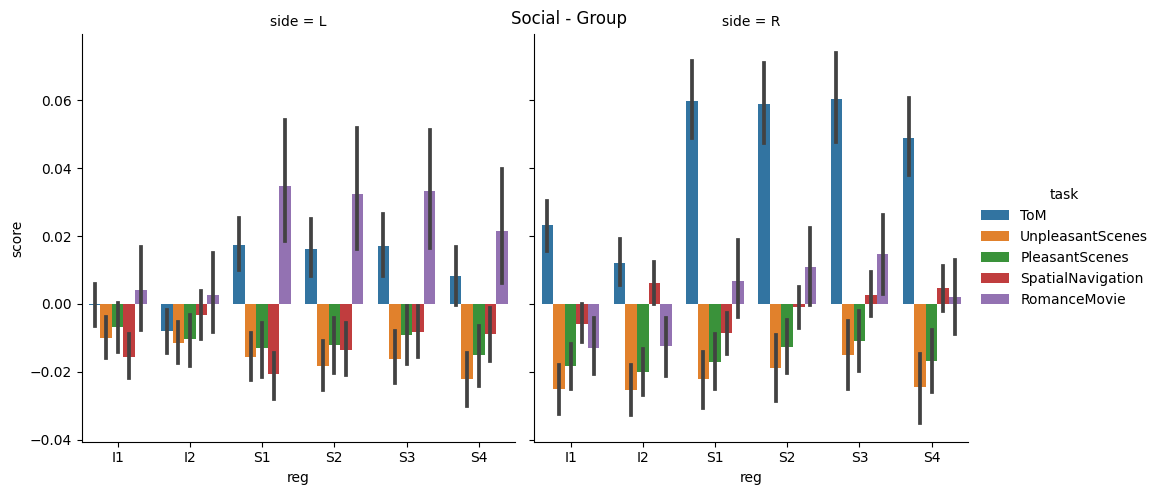

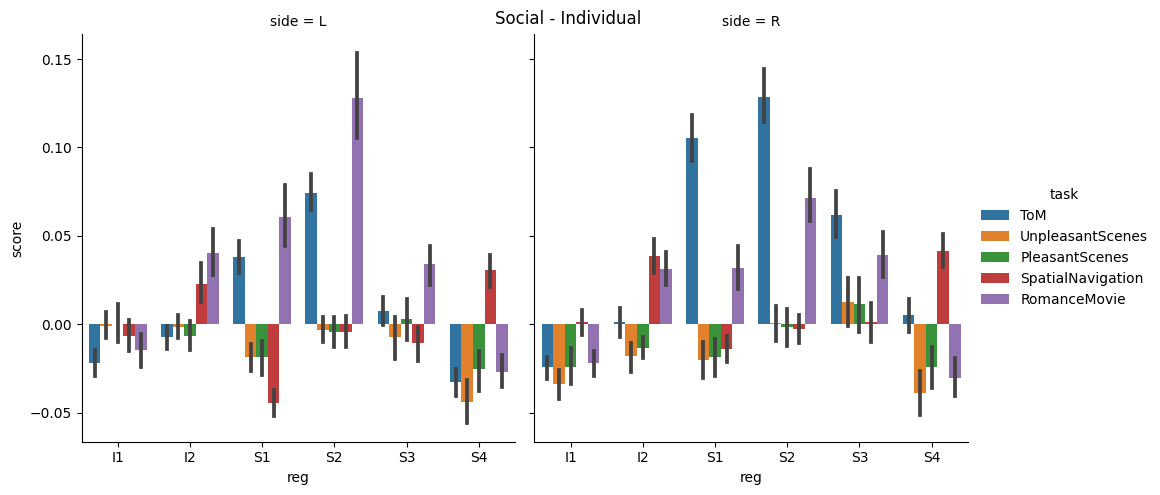

In [232]:

tasks_social = ['ToM', 'UnpleasantScenes',
                'PleasantScenes', 'SadFaces'
                'HappyFaces', 'SpatialNavigation', 'RomanceMovie']
tasks_action = ['VideoAct', 'VideoKnots', 'NatureMovie', 'LandscapeMovie',
                'BodyMotionIntact', 'BodyMotionScram']
tasks_motor = ['MotorImagery', 'FingerSeq','FingerSimple']

nets = ['M', 'S']
plt.figure(figsize=(15, 6))
fig = sb.catplot(data=data_group[data_group.task.isin(tasks_social) & data_group.net.isin(nets)], kind='bar', col='side',
           x='reg', y='score', hue='task')
fig.fig.suptitle('Social - Group')
fig = sb.catplot(data=data_indiv[data_indiv.task.isin(tasks_social) & data_indiv.net.isin(nets)], kind='bar', col='side',
           x='reg', y='score', hue='task')
fig.fig.suptitle('Social - Individual')



Text(0.5, 0.98, 'Action - Individual')

<Figure size 1500x600 with 0 Axes>

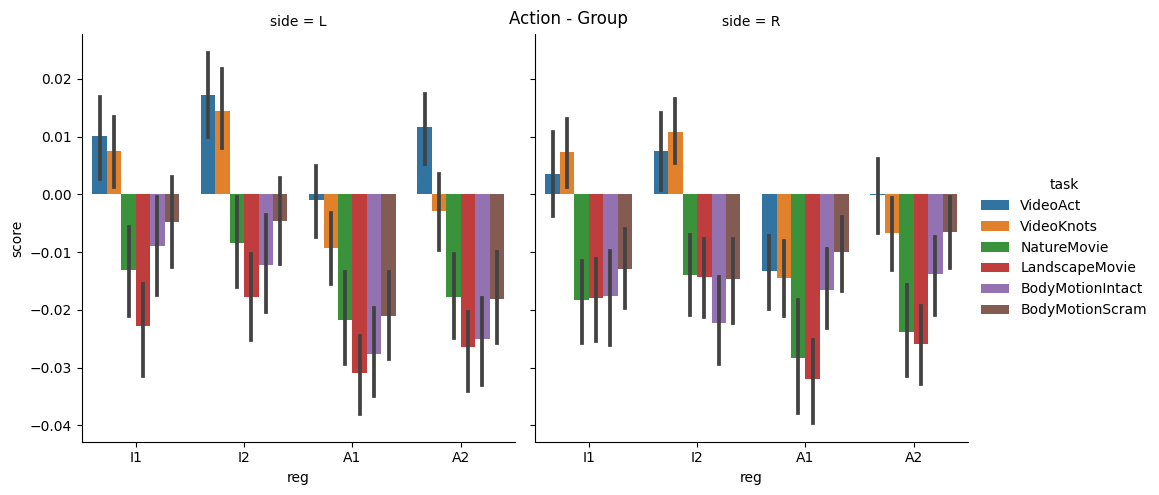

<Figure size 1500x600 with 0 Axes>

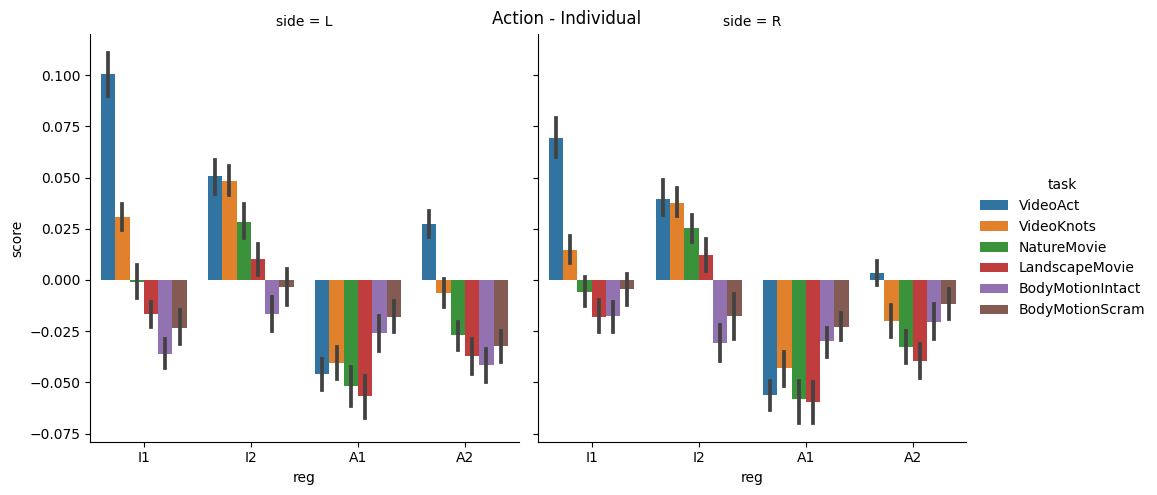

In [233]:

nets = ['M', 'A']
plt.figure(figsize=(15, 6))
fig = sb.catplot(data=data_group[data_group.task.isin(tasks_action) & data_group.net.isin(nets)], kind='bar', col='side',
                 x='reg', y='score', hue='task')
fig.fig.suptitle('Action - Group')
plt.figure(figsize=(15, 6))
fig = sb.catplot(data=data_indiv[data_indiv.task.isin(tasks_action) & data_indiv.net.isin(nets)], kind='bar', col='side',
                 x='reg', y='score', hue='task')
fig.fig.suptitle('Action - Individual')


Text(0.5, 0.98, 'Motor - Individual')

<Figure size 1500x600 with 0 Axes>

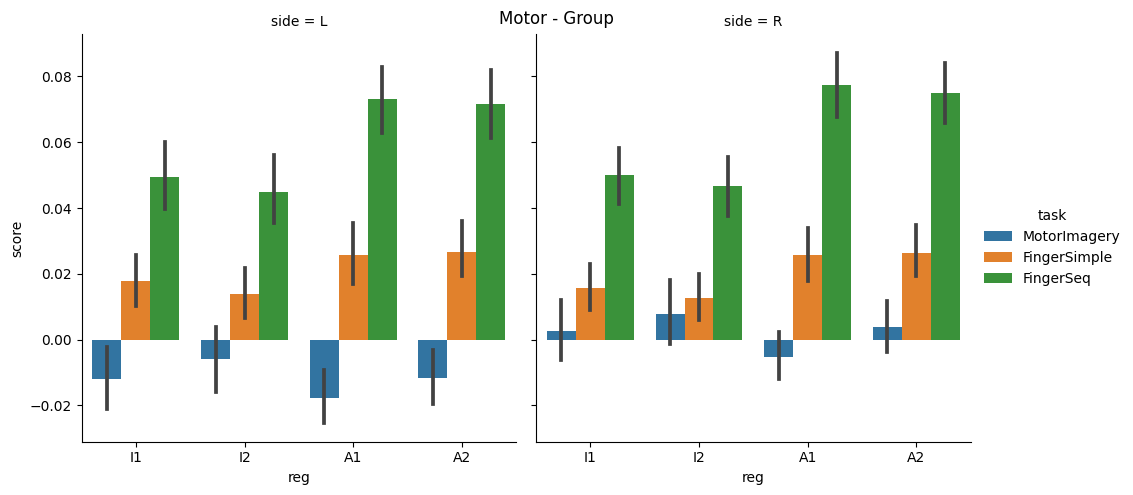

<Figure size 1500x600 with 0 Axes>

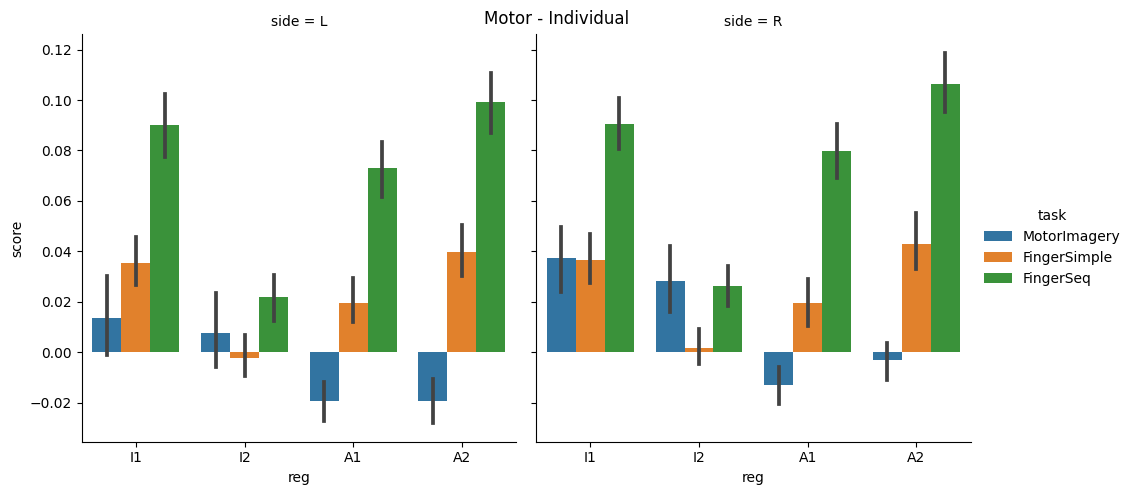

In [234]:

nets = ['M', 'A']
plt.figure(figsize=(15, 6))
fig = sb.catplot(data=data_group[data_group.task.isin(tasks_motor) & data_group.net.isin(nets)], kind='bar', col='side',
                       x='reg', y='score', hue='task')
fig.fig.suptitle('Motor - Group')

plt.figure(figsize=(15, 6))
fig = sb.catplot(data=data_indiv[data_indiv.task.isin(tasks_motor) & data_indiv.net.isin(nets)], kind='bar', col='side',
                          x='reg', y='score', hue='task')
fig.fig.suptitle('Motor - Individual')


## Compare I regions with A and S regions

### Region A3

In [235]:
def scatter_plot(compare, data, title):
    region1 = data[data.reg == compare[0]]
    region2 = data[data.reg == compare[1]]
    # Average within each task
    region1 = region1.groupby(['task']).mean().reset_index()
    region2 = region2.groupby(['task']).mean().reset_index()
    plt.scatter(region1.score, region2.score)

    # Add labels to the dots
    for i in range(len(region1)):
        plt.annotate(f'{region1.iloc[i].task}',
                     (region1.iloc[i].score, region2.iloc[i].score))

    # Label
    plt.xlabel(compare[0])
    plt.ylabel(compare[1])
    # Insert lines
    plt.axhline(0, color='k', linestyle='--')
    plt.axvline(0, color='k', linestyle='--')
    plt.title(title)

/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_53505/2764687942.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  region1 = region1.groupby(['task']).mean().reset_index()
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_53505/2764687942.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  region2 = region2.groupby(['task']).mean().reset_index()
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_53505/2764687942.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify n

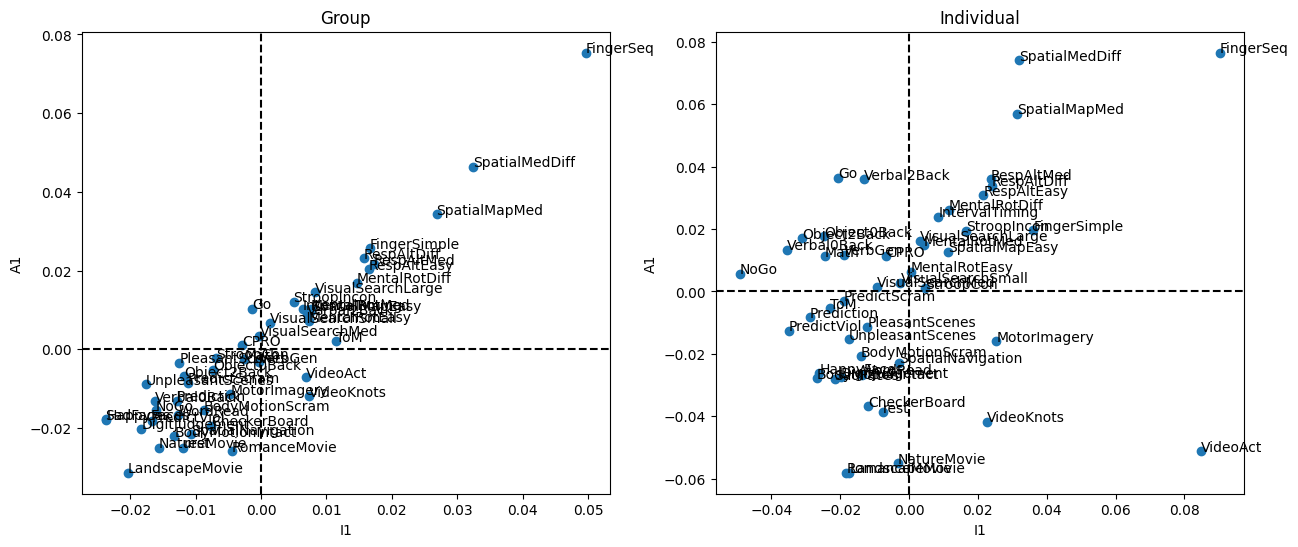

In [236]:
# Annotated correlation plots
compare = ['A3', 'A1']
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
scatter_plot(compare, data_group, 'Group')
plt.subplot(1, 2, 2)
scatter_plot(compare, data_indiv, 'Individual')


### Region A4

/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_53505/2764687942.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  region1 = region1.groupby(['task']).mean().reset_index()
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_53505/2764687942.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  region2 = region2.groupby(['task']).mean().reset_index()
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_53505/2764687942.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify n

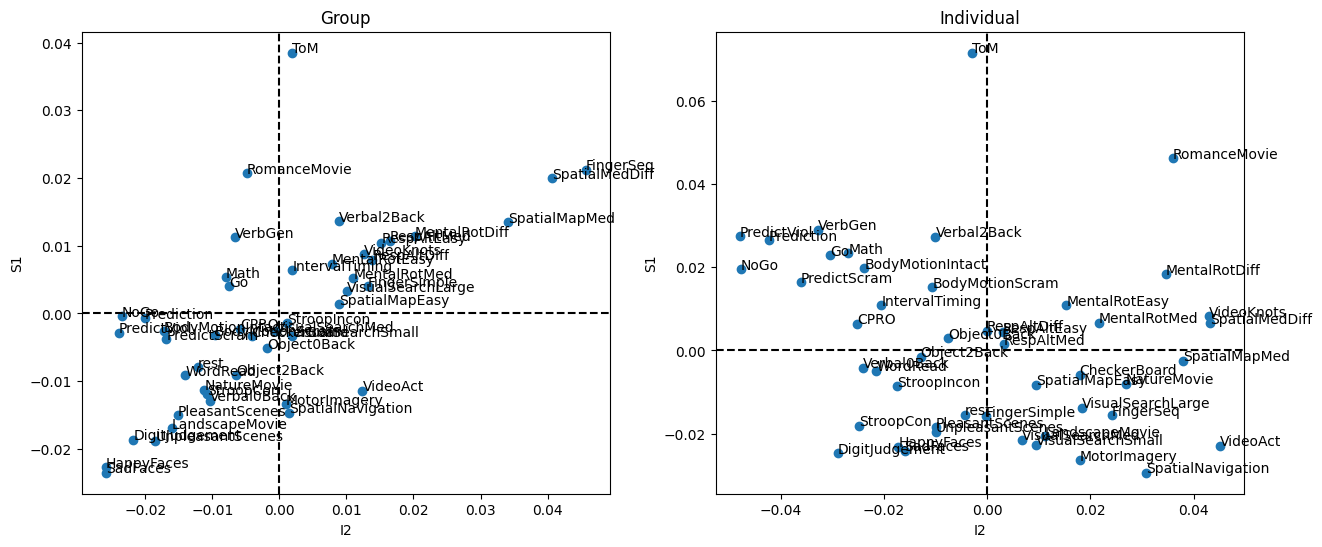

In [237]:
# Annotated correlation plots
compare = ['A4', 'S1']
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
scatter_plot(compare, data_group, 'Group')
plt.subplot(1, 2, 2)
scatter_plot(compare, data_indiv, 'Individual')

/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_53505/2764687942.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  region1 = region1.groupby(['task']).mean().reset_index()
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_53505/2764687942.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  region2 = region2.groupby(['task']).mean().reset_index()
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_53505/2764687942.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify n

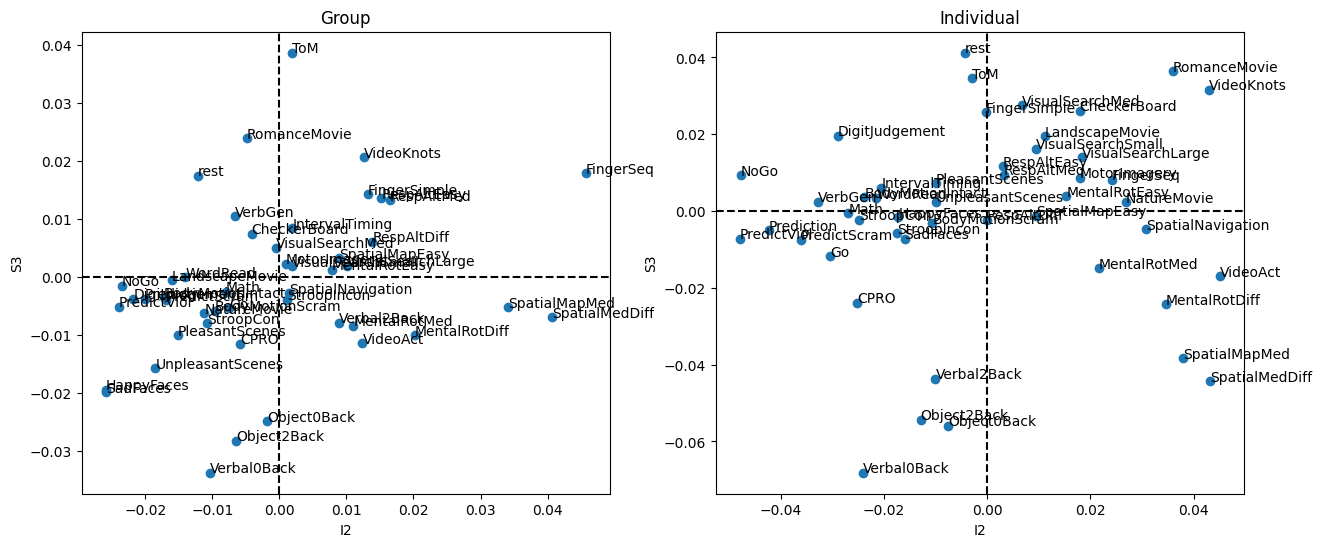

In [238]:
# Annotated correlation plots
compare = ['A4', 'S3']
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
scatter_plot(compare, data_group, 'Group')
plt.subplot(1, 2, 2)
scatter_plot(compare, data_indiv, 'Individual')


/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_53505/2764687942.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  region1 = region1.groupby(['task']).mean().reset_index()
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_53505/2764687942.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  region2 = region2.groupby(['task']).mean().reset_index()
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_53505/2764687942.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify n

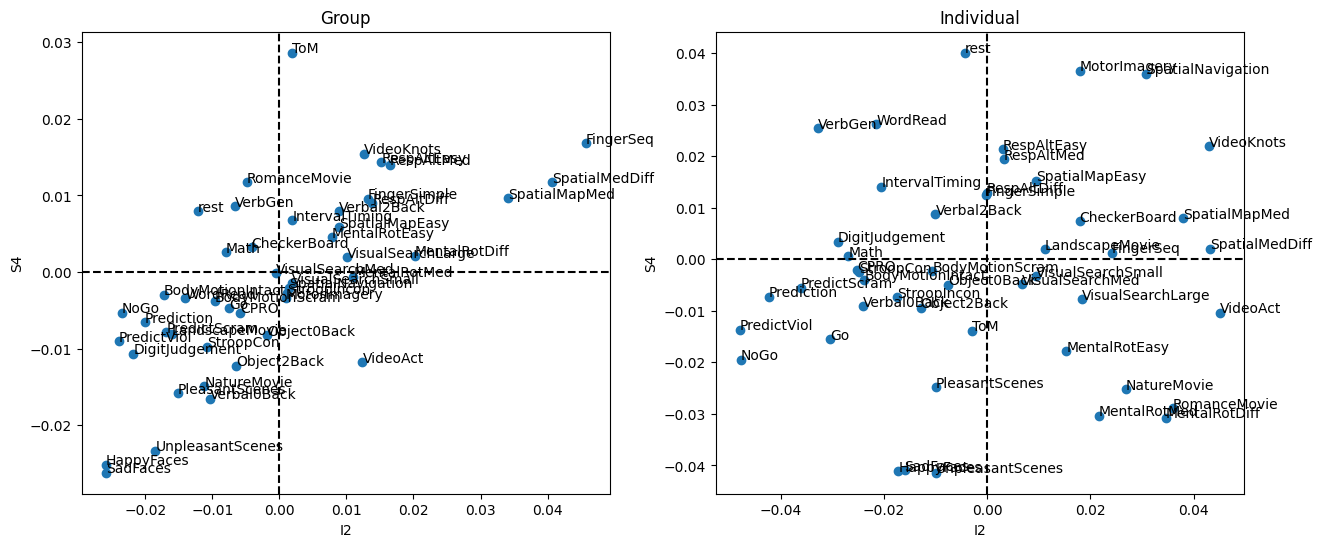

In [240]:
# Annotated correlation plots
compare = ['A4', 'S4']
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
scatter_plot(compare, data_group, 'Group')
plt.subplot(1, 2, 2)
scatter_plot(compare, data_indiv, 'Individual')


## Contrast regions across all tasks

In [241]:
def line_plot(contrast_regions, data_group, data_indiv):
    selected_colors = [color for region, color in zip(
        regions[::2], reg_colors) if region[:2] in contrast_regions]
    
    # Plot group
    plt.figure(figsize=(15, 6))
    plt.subplot(2, 1, 1)
    fig = sb.lineplot(data=data_group[data_group.reg.isin(contrast_regions)], x='condition', y='score',
                      hue='reg', style='net', palette=selected_colors, legend=False)
    fig.set_xticklabels(fig.get_xticklabels(), rotation=90, ha="right")
    plt.title('Group')

    # Plot individual
    plt.subplot(2, 1, 2)
    fig = sb.lineplot(data=data_indiv[data_indiv.reg.isin(
        contrast_regions)], x='condition', y='score', hue='reg', style='net', palette=selected_colors)
    fig.set_xticklabels(fig.get_xticklabels(), rotation=90, ha="right")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Individual')
    plt.tight_layout()
    plt.show()



/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_53505/562509231.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(fig.get_xticklabels(), rotation=90, ha="right")
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_53505/562509231.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(fig.get_xticklabels(), rotation=90, ha="right")


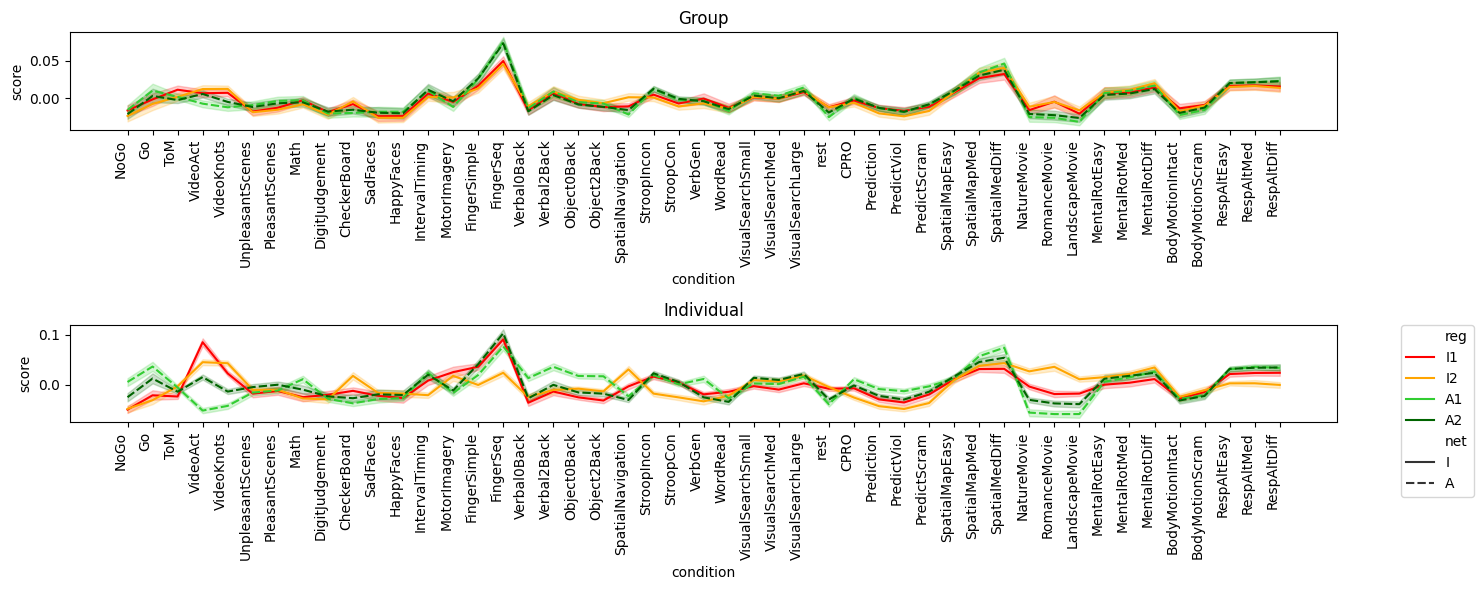

/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_53505/562509231.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(fig.get_xticklabels(), rotation=90, ha="right")
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_53505/562509231.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(fig.get_xticklabels(), rotation=90, ha="right")


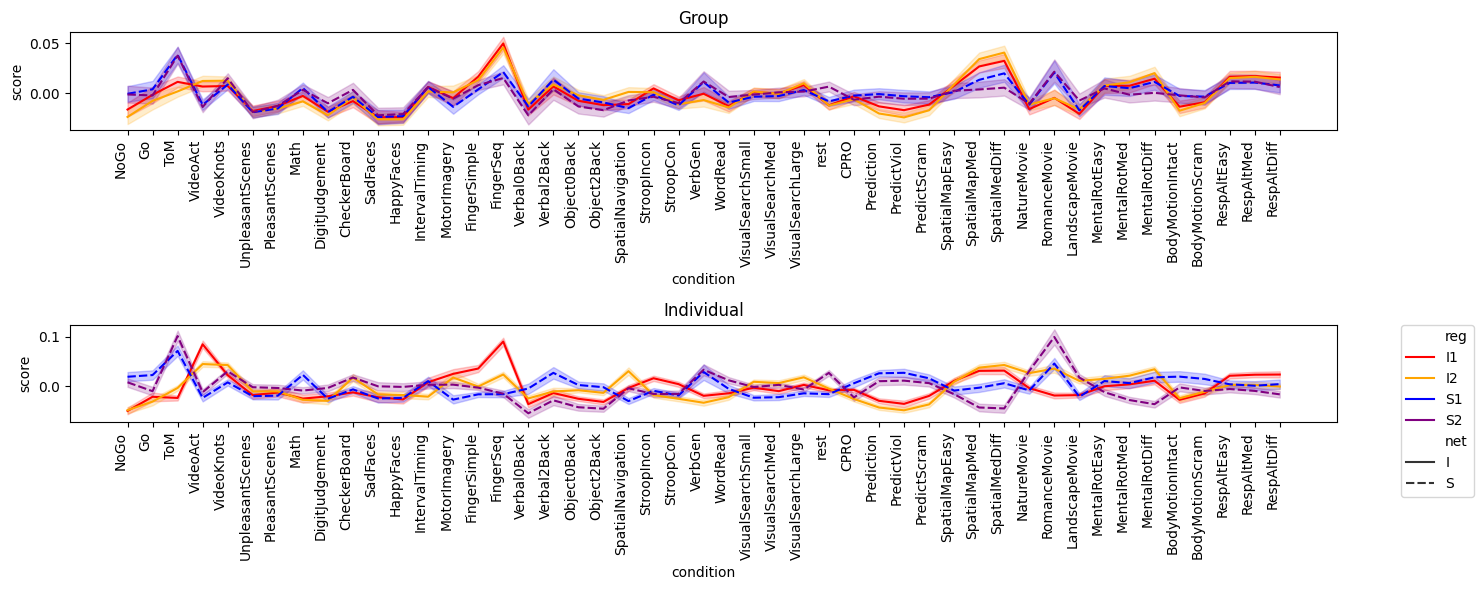

/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_53505/562509231.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(fig.get_xticklabels(), rotation=90, ha="right")
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_53505/562509231.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(fig.get_xticklabels(), rotation=90, ha="right")


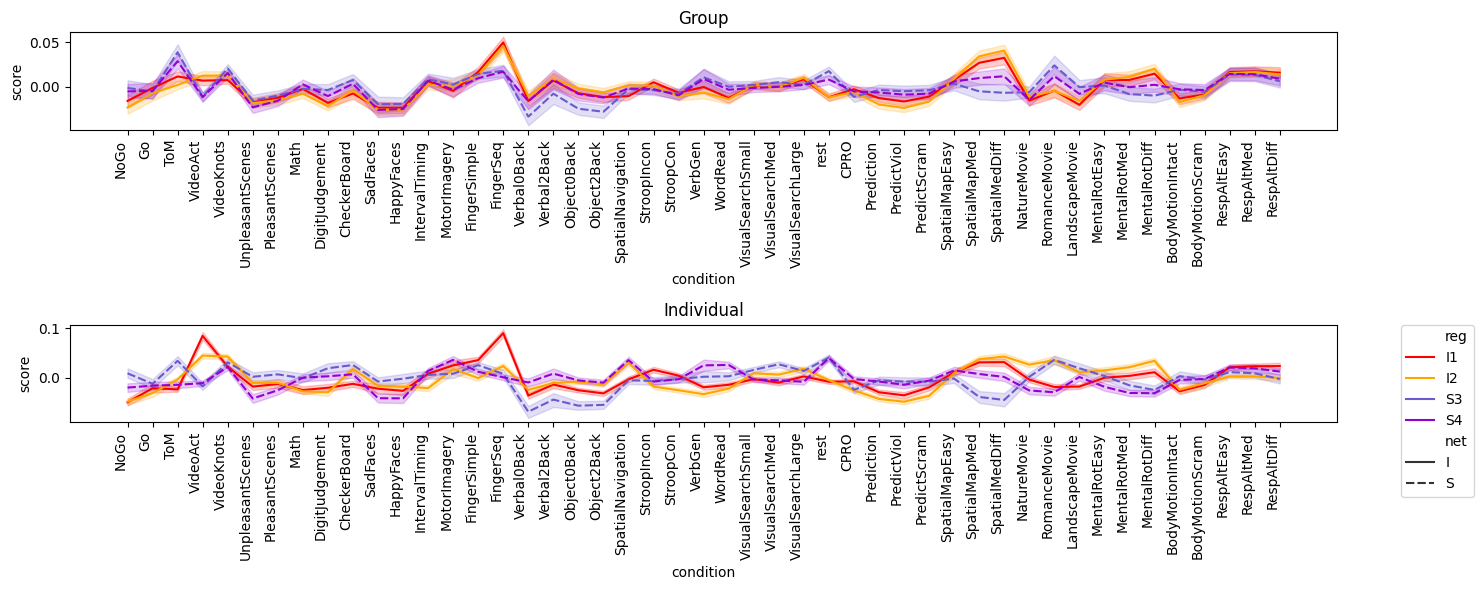

In [242]:
contrast_regions = ['A3', 'A4', 'A1', 'A2']
line_plot(contrast_regions, data_group, data_indiv)


contrast_regions = ['A3', 'A4', 'S1', 'S2']
line_plot(contrast_regions, data_group, data_indiv)

contrast_regions = ['A3', 'A4', 'S3', 'S4']
line_plot(contrast_regions, data_group, data_indiv)

/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_53505/562509231.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(fig.get_xticklabels(), rotation=90, ha="right")
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_53505/562509231.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(fig.get_xticklabels(), rotation=90, ha="right")


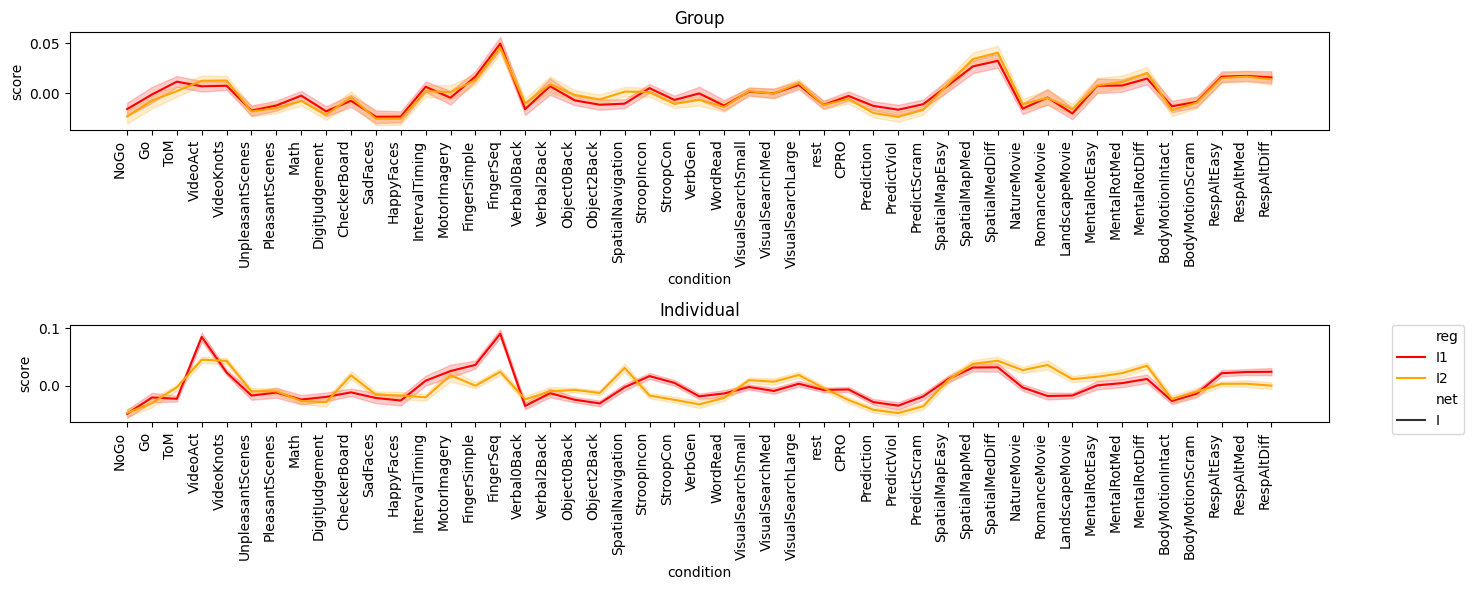

In [243]:
contrast_regions = ['A3', 'A4', 'M1', 'M4']
line_plot(contrast_regions, data_group, data_indiv)
